In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle


In [ ]:
!kaggle datasets download -d stoney71/new-york-city-transport-statistics

Dataset URL: https://www.kaggle.com/datasets/stoney71/new-york-city-transport-statistics
License(s): unknown
 98% 1.28G/1.30G [00:06<00:00, 234MB/s]
100% 1.30G/1.30G [00:08<00:00, 167MB/s]


In [ ]:
!unzip -o new-york-city-transport-statistics.zip -d ./nyc_transport_data

Archive:  new-york-city-transport-statistics.zip
  inflating: ./nyc_transport_data/mta_1706.csv  
  inflating: ./nyc_transport_data/mta_1708.csv  
  inflating: ./nyc_transport_data/mta_1710.csv  
  inflating: ./nyc_transport_data/mta_1712.csv  


##1. Data Ingestion & Storage

In [ ]:
#1. Load Large Data File into Spark
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("NYC_Transport_Analysis").getOrCreate()

# Load CSV into DataFrame
df = spark.read.option("header", True).option("inferSchema", True).csv("/content/nyc_transport_data/mta_1712.csv")

# Preview data
df.show(5)
df.printSchema()


+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|     RecordedAtTime|DirectionRef|PublishedLineName|          OriginName|OriginLat|OriginLong|     DestinationName|DestinationLat|DestinationLong|VehicleRef|VehicleLocation.Latitude|VehicleLocation.Longitude|   NextStopPointName|ArrivalProximityText|DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+------------------------+-------------------------+--------------------+--------------------+----------------+-------------------+--------------------+
|2017-12-01 00:05:49|           0|              B67|MC DONALD AV/CORT...|

In [ ]:
#2. Convert DataFrame to RDD
# Convert to RDD
rdd = df.rdd

# Show first 5 rows as RDD
rdd.take(5)


[Row(RecordedAtTime=datetime.datetime(2017, 12, 1, 0, 5, 49), DirectionRef='0', PublishedLineName='B67', OriginName='MC DONALD AV/CORTELYOU RD', OriginLat='40.63816', OriginLong='-73.978939', DestinationName='DNTWN BKLYN SANDS ST via FLATBUSH AV', DestinationLat='40.700253', DestinationLong='-73.98703', VehicleRef='NYCT_406', VehicleLocation.Latitude=40.671578, VehicleLocation.Longitude=-73.977672, NextStopPointName='7 AV/GARFIELD PL', ArrivalProximityText='approaching', DistanceFromStop='130', ExpectedArrivalTime='2017-12-01 00:06:21', ScheduledArrivalTime='24:01:30'),
 Row(RecordedAtTime=datetime.datetime(2017, 12, 1, 0, 6, 19), DirectionRef='1', PublishedLineName='Bx7', OriginName='RIVERDALE AV/W 263 ST', OriginLat='40.912363', OriginLong='-73.902699', DestinationName='WASHINGTON HEIGHTS 166 ST via BROADWAY', DestinationLat='40.839813', DestinationLong='-73.939745', VehicleRef='NYCT_4223', VehicleLocation.Latitude=40.866243, VehicleLocation.Longitude=-73.925258, NextStopPointName='B

In [ ]:
df.printSchema()
df.columns
df.show(5)


root
 |-- RecordedAtTime: timestamp (nullable = true)
 |-- DirectionRef: string (nullable = true)
 |-- PublishedLineName: string (nullable = true)
 |-- OriginName: string (nullable = true)
 |-- OriginLat: string (nullable = true)
 |-- OriginLong: string (nullable = true)
 |-- DestinationName: string (nullable = true)
 |-- DestinationLat: string (nullable = true)
 |-- DestinationLong: string (nullable = true)
 |-- VehicleRef: string (nullable = true)
 |-- VehicleLocation.Latitude: double (nullable = true)
 |-- VehicleLocation.Longitude: double (nullable = true)
 |-- NextStopPointName: string (nullable = true)
 |-- ArrivalProximityText: string (nullable = true)
 |-- DistanceFromStop: string (nullable = true)
 |-- ExpectedArrivalTime: string (nullable = true)
 |-- ScheduledArrivalTime: string (nullable = true)

+-------------------+------------+-----------------+--------------------+---------+----------+--------------------+--------------+---------------+----------+-----------------------

In [ ]:
 #2. Use RDDs for Basic Transformations
 #Example Task: Count how many times each destination appears
 # Convert to RDD
rdd = df.rdd

# Filter rows with non-null DestinationName
filtered_rdd = rdd.filter(lambda row: row.DestinationName is not None)

# Map to (DestinationName, 1)
dest_counts = filtered_rdd.map(lambda row: (row.DestinationName, 1))

# Reduce to get total counts
dest_totals = dest_counts.reduceByKey(lambda a, b: a + b)

# Display sample output
dest_totals.take(10)



[('EAST VIL 6 ST via LEX AV', 19525),
 ('WARDS ISLAND', 3454),
 ('SELECT BUS SI MALL via HYLAN', 19933),
 ('JAMAICA PRSNS - ARCHR via LINDEN', 12889),
 ('44 ST 6 AV', 10676),
 ('FLORAL PARK 268 ST via HILLSIDE', 14897),
 ('BROWNSVILLE ROCKAWAY AV', 27156),
 ('WILLAMSBURG BRIDGE PLZ via NOSTRAND', 3727),
 ('CITY HALL via LEX AV', 20667),
 ('GREENPOINT BOX ST', 18877)]

In [ ]:
# Example Task: Average distance from stop per destination
# Ensure valid numeric DistanceFromStop values
# Convert to RDD
rdd = df.rdd

# Clean and filter rows with numeric DistanceFromStop values
def is_valid_distance(row):
    try:
        return row.DestinationName is not None and float(row.DistanceFromStop)
    except:
        return False

# Only keep rows with numeric DistanceFromStop
cleaned_rdd = rdd.filter(is_valid_distance)

# Map to (DestinationName, (DistanceFromStop as float, 1))
distance_rdd = cleaned_rdd.map(lambda row: (row.DestinationName, (float(row.DistanceFromStop), 1)))

# Reduce to get total distance and count
sum_counts = distance_rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Compute average distance
avg_distance = sum_counts.mapValues(lambda x: x[0] / x[1])

# Display top 10 results
avg_distance.take(10)



[('EAST VIL 6 ST via LEX AV', 109.55831320008785),
 ('JAMAICA PRSNS - ARCHR via LINDEN', 140.71036734693877),
 ('44 ST 6 AV', 124.51325621865084),
 ('FLORAL PARK 268 ST via HILLSIDE', 95.60459128942287),
 ('BROWNSVILLE ROCKAWAY AV', 90.64920573421155),
 ('WILLAMSBURG BRIDGE PLZ via NOSTRAND', 100.0868809730669),
 ('CITY HALL via LEX AV', 124.24577626711987),
 ('GREENPOINT BOX ST', 123.51275129236072),
 ('BAY RIDGE SHORE RD via BROADWAY', 1172.9580586337495),
 ('SHEEPSHEAD BAY KNAPP ST', 94.6242663021629)]

In [ ]:
#3. Convert RDDs to DataFrames for SQL-Based Operations
# Convert to DataFrame
avg_df = avg_distance.toDF(["Destination", "Avg_Distance_From_Stop"])

# Register as SQL view
avg_df.createOrReplaceTempView("avg_distances")

# Run SQL query
spark.sql("SELECT * FROM avg_distances ORDER BY Avg_Distance_From_Stop DESC LIMIT 10").show()


+--------------------+----------------------+
|         Destination|Avg_Distance_From_Stop|
+--------------------+----------------------+
|SUPER EXPRESS BAY...|    10277.941176470587|
|SUPER EXPRESS DOW...|               8893.52|
|SUPER EXPRESS ELT...|     7153.484589041096|
|SUPER EXPRESS GLE...|      7033.88679245283|
|ELTINGVILLE TRANS...|     6519.314891655141|
|SUPER EXPRESS 42S...|    6470.3512605042015|
|SP EX TTNVLL via ...|     6328.688131313132|
|TOTTNVLLE via RSS...|     6109.036144578313|
|TOTTENVILLE via N...|     6056.993319725367|
|SUNNYSIDE via NEW...|     5705.278413424867|
+--------------------+----------------------+



##2. Data Cleaning and Exploration

In [ ]:
from pyspark.sql.functions import col, when, count, isnan

# Identify numeric columns correctly with backticks for special chars like dots
numeric_cols = ["`VehicleLocation.Latitude`", "`VehicleLocation.Longitude`"]

exprs = []

for c in df.columns:
    if c in ["VehicleLocation.Latitude", "VehicleLocation.Longitude"]:
        exprs.append(count(when(col(f"`{c}`").isNull() | isnan(col(f"`{c}`")), c)).alias(c))
    else:
        exprs.append(count(when(col(c).isNull(), c)).alias(c))

# Execute and show null counts
df.select(exprs).show(truncate=False)


+--------------+------------+-----------------+----------+---------+----------+---------------+--------------+---------------+----------+------------------------+-------------------------+-----------------+--------------------+----------------+-------------------+--------------------+
|RecordedAtTime|DirectionRef|PublishedLineName|OriginName|OriginLat|OriginLong|DestinationName|DestinationLat|DestinationLong|VehicleRef|VehicleLocation.Latitude|VehicleLocation.Longitude|NextStopPointName|ArrivalProximityText|DistanceFromStop|ExpectedArrivalTime|ScheduledArrivalTime|
+--------------+------------+-----------------+----------+---------+----------+---------------+--------------+---------------+----------+------------------------+-------------------------+-----------------+--------------------+----------------+-------------------+--------------------+
|0             |0           |0                |0         |0        |0         |0              |0             |0              |0         |0    

In [ ]:
 #Drop rows with critical null values
 df_clean = df.dropna(subset=["DestinationName", "DistanceFromStop"])


In [ ]:
#2. Handling Duplicates
print("Before removing duplicates:", df_clean.count())
df_clean = df_clean.dropDuplicates()
print("After removing duplicates:", df_clean.count())


Before removing duplicates: 6461753
After removing duplicates: 6435529


In [ ]:
# 3. Data Type Consistency
df_clean = df_clean.withColumn("DistanceFromStop", col("DistanceFromStop").cast("double"))
df_clean.printSchema()


root
 |-- RecordedAtTime: timestamp (nullable = true)
 |-- DirectionRef: string (nullable = true)
 |-- PublishedLineName: string (nullable = true)
 |-- OriginName: string (nullable = true)
 |-- OriginLat: string (nullable = true)
 |-- OriginLong: string (nullable = true)
 |-- DestinationName: string (nullable = true)
 |-- DestinationLat: string (nullable = true)
 |-- DestinationLong: string (nullable = true)
 |-- VehicleRef: string (nullable = true)
 |-- VehicleLocation.Latitude: double (nullable = true)
 |-- VehicleLocation.Longitude: double (nullable = true)
 |-- NextStopPointName: string (nullable = true)
 |-- ArrivalProximityText: string (nullable = true)
 |-- DistanceFromStop: double (nullable = true)
 |-- ExpectedArrivalTime: string (nullable = true)
 |-- ScheduledArrivalTime: string (nullable = true)



In [ ]:
#4. Spark SQL for Querying & Aggregation
df_clean.createOrReplaceTempView("transport_data")


In [ ]:
#Count trips per destination
spark.sql("""
    SELECT DestinationName, COUNT(*) AS total_trips
    FROM transport_data
    GROUP BY DestinationName
    ORDER BY total_trips DESC
    LIMIT 10
""").show()


+--------------------+-----------+
|     DestinationName|total_trips|
+--------------------+-----------+
|WASHINGTON HTS GW...|      83890|
|     ST GEORGE FERRY|      59275|
|FLUSHING  MAIN ST...|      52661|
|W FARMS RD SOUTHE...|      49139|
|FLUSHING MAIN ST STA|      42885|
|SELECT BUS BRONX ...|      41243|
|SELECT BUS JAMAIC...|      40060|
|BED-STUY WOODHULL...|      39049|
|      WESTCHESTER SQ|      36735|
|         PT RICHMOND|      35323|
+--------------------+-----------+



In [ ]:
# Average distance from stop per destination
spark.sql("""
    SELECT DestinationName, ROUND(AVG(DistanceFromStop), 2) AS avg_distance
    FROM transport_data
    GROUP BY DestinationName
    ORDER BY avg_distance DESC
    LIMIT 10
""").show()


+--------------------+------------+
|     DestinationName|avg_distance|
+--------------------+------------+
|SUPER EXPRESS BAY...|     9706.94|
|SUPER EXPRESS DOW...|     8893.52|
|SUPER EXPRESS ELT...|     6787.38|
|SUPER EXPRESS GLE...|     6778.11|
|SUPER EXPRESS 42S...|      6244.7|
|ELTINGVILLE TRANS...|     6076.66|
|SP EX TTNVLL via ...|     6046.23|
|TOTTENVILLE via N...|     5728.53|
|SUNNYSIDE via NEW...|     5544.57|
|TOTTNVLLE via RSS...|     5426.22|
+--------------------+------------+



##3: Feature Engineering

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Fix: Cast distance to float safely inside the UDF
def categorize_distance(dist):
    try:
        dist = float(dist)
        if dist < 100:
            return "Near"
        elif dist < 500:
            return "Medium"
        else:
            return "Far"
    except:
        return "Unknown"

# Register the UDF
distance_category_udf = udf(categorize_distance, StringType())

# Apply UDF
df_fe = df.withColumn("DistanceCategory", distance_category_udf(df["DistanceFromStop"]))

# Show results
df_fe.select("DistanceFromStop", "DistanceCategory").show(5)


+----------------+----------------+
|DistanceFromStop|DistanceCategory|
+----------------+----------------+
|             130|          Medium|
|              14|            Near|
|             209|          Medium|
|               5|            Near|
|             108|          Medium|
+----------------+----------------+
only showing top 5 rows



In [ ]:
# Drop rows where DistanceFromStop is null
df_fe_clean = df_fe.filter(df_fe["DistanceFromStop"].isNotNull())


In [ ]:
#Normalize/scale features
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Step 0: Remove rows where DistanceFromStop is null or invalid
df_filtered = df_fe.filter((col("DistanceFromStop").isNotNull()) & (col("DistanceFromStop") != 'NA'))

# Step 1: Cast DistanceFromStop to double
df_casted = df_filtered.withColumn("DistanceFromStop", col("DistanceFromStop").cast(DoubleType()))

# (Optional: Verify that all rows are now numeric and non-null)
df_casted.select("DistanceFromStop").filter(col("DistanceFromStop").isNull()).show()



+----------------+
|DistanceFromStop|
+----------------+
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
|            NULL|
+----------------+
only showing top 20 rows



In [ ]:
#vector assemble
# Step 2: Assemble vector
assembler = VectorAssembler(
    inputCols=["DistanceFromStop"],
    outputCol="distance_vec",
    handleInvalid="skip"  # Optional, just in case
)
assembled_df = assembler.transform(df_casted)


In [ ]:
#minmax scalar
# Step 3: Apply MinMaxScaler
scaler = MinMaxScaler(inputCol="distance_vec", outputCol="distance_scaled")
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# Show final scaled output
scaled_df.select("DistanceFromStop", "distance_scaled").show(5)


+----------------+--------------------+
|DistanceFromStop|     distance_scaled|
+----------------+--------------------+
|           130.0|[0.00362227980718...|
|            14.0|[3.90091671542812...|
|           209.0|[0.00582351138231...|
|             5.0|[1.39318454122433...|
|           108.0|[0.00300927860904...|
+----------------+--------------------+
only showing top 5 rows



In [ ]:
# 3. Encode Categorical Data
from pyspark.ml.feature import StringIndexer

# Encode DirectionRef
indexer1 = StringIndexer(inputCol="DirectionRef", outputCol="DirectionIndex")
df_indexed = indexer1.fit(scaled_df).transform(scaled_df)

# Encode ArrivalProximityText
indexer2 = StringIndexer(inputCol="ArrivalProximityText", outputCol="ProximityIndex")
df_indexed = indexer2.fit(df_indexed).transform(df_indexed)

df_indexed.select("DirectionRef", "DirectionIndex", "ArrivalProximityText", "ProximityIndex").show(5)


+------------+--------------+--------------------+--------------+
|DirectionRef|DirectionIndex|ArrivalProximityText|ProximityIndex|
+------------+--------------+--------------------+--------------+
|           0|           1.0|         approaching|           0.0|
|           1|           0.0|             at stop|           2.0|
|           0|           1.0|       < 1 stop away|           1.0|
|           0|           1.0|             at stop|           2.0|
|           0|           1.0|         approaching|           0.0|
+------------+--------------+--------------------+--------------+
only showing top 5 rows



##4: Machine Learning Module (MLlib)


Predict whether a vehicle is "Near" or "Far" from its stop based on features like DirectionRef, ArrivalProximityText, and DistanceFromStop.

(We use the DistanceCategory created earlier as a binary label: Near = 0, Medium/Far = 1)

In [ ]:
# Check if 'label' is inside 'features'
assembler.getInputCols()


['DistanceFromStop', 'DirectionIndex', 'ProximityIndex']

In [ ]:
#1. Prepare Features and Label
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Binary label: Near = 0, else = 1
df_ml = scaled_df.withColumn("label", when(col("DistanceCategory") == "Near", 0).otherwise(1))

# Encode categorical variables
direction_indexer = StringIndexer(inputCol="DirectionRef", outputCol="DirectionIndex")
proximity_indexer = StringIndexer(inputCol="ArrivalProximityText", outputCol="ProximityIndex")

df_ml = direction_indexer.fit(df_ml).transform(df_ml)
df_ml = proximity_indexer.fit(df_ml).transform(df_ml)



In [ ]:
#2. Assemble All Features into a Single Vector
assembler = VectorAssembler(
    inputCols=["DirectionIndex", "ProximityIndex"],
    outputCol="features"
)


final_df = assembler.transform(df_ml).select("features", "label")
final_df.show(5)


+---------+-----+
| features|label|
+---------+-----+
|[1.0,0.0]|    1|
|[0.0,2.0]|    0|
|[1.0,1.0]|    1|
|[1.0,2.0]|    0|
|[1.0,0.0]|    1|
+---------+-----+
only showing top 5 rows



In [ ]:
#3. Split Data
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
#4. Train Models
#logistic regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)
lr_preds = lr_model.transform(test_data)


In [ ]:
#decission tree
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxBins=256)
dt_model = dt.fit(train_data)
dt_preds = dt_model.transform(test_data)


In [ ]:
#Classifiaction report
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from sklearn.metrics import classification_report

def evaluate_classification_model(pred_df, model_name="Model"):
    print(f"\n📊 Evaluation Metrics for: {model_name}")

    # Convert to Pandas for sklearn
    pred_pd = pred_df.select("label", "prediction").toPandas()

    # Classification report from sklearn
    report = classification_report(pred_pd["label"], pred_pd["prediction"], target_names=["Near", "Medium/Far"])
    print(report)


In [ ]:
#applying to models
evaluate_classification_model(lr_preds, model_name="Logistic Regression")
evaluate_classification_model(dt_preds, model_name="Decision Tree")




📊 Evaluation Metrics for: Logistic Regression
              precision    recall  f1-score   support

        Near       0.54      1.00      0.70    681510
  Medium/Far       1.00      0.05      0.09    609935

    accuracy                           0.55   1291445
   macro avg       0.77      0.52      0.40   1291445
weighted avg       0.76      0.55      0.41   1291445


📊 Evaluation Metrics for: Decision Tree
              precision    recall  f1-score   support

        Near       0.80      1.00      0.89    681510
  Medium/Far       1.00      0.72      0.84    609935

    accuracy                           0.87   1291445
   macro avg       0.90      0.86      0.86   1291445
weighted avg       0.89      0.87      0.86   1291445



In [ ]:
#confusion matrix
# Logistic Regression
lr_preds.groupBy("label", "prediction").count().show()

# Decision Tree
dt_preds.groupBy("label", "prediction").count().show()


+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    0|       0.0|681301|
|    1|       1.0|610144|
+-----+----------+------+

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    0|       0.0|681301|
|    1|       1.0|610144|
+-----+----------+------+



In [ ]:
# Check label distribution
train_data.groupBy("label").count().show()
test_data.groupBy("label").count().show()


+-----+-------+
|label|  count|
+-----+-------+
|    1|2433941|
|    0|2728905|
+-----+-------+

+-----+------+
|label| count|
+-----+------+
|    1|610144|
|    0|681301|
+-----+------+



##5: Visualization & Reporting


In [ ]:
#1. Display Insights from Spark SQL
# Register as SQL view
df_fe.createOrReplaceTempView("transport_data")

# SQL Query: Top destinations
top_dest_df = spark.sql("""
    SELECT DestinationName, COUNT(*) AS trip_count
    FROM transport_data
    GROUP BY DestinationName
    ORDER BY trip_count DESC
    LIMIT 10
""")

top_dest_df.show()


+--------------------+----------+
|     DestinationName|trip_count|
+--------------------+----------+
|WASHINGTON HTS GW...|     84246|
|     ST GEORGE FERRY|     59546|
|FLUSHING  MAIN ST...|     52847|
|W FARMS RD SOUTHE...|     49350|
|FLUSHING MAIN ST STA|     43073|
|SELECT BUS BRONX ...|     41384|
|SELECT BUS JAMAIC...|     40200|
|BED-STUY WOODHULL...|     39190|
|      WESTCHESTER SQ|     36893|
|         PT RICHMOND|     35456|
+--------------------+----------+



/tmp/ipython-input-1467433406.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_dest_pd, x="trip_count", y="DestinationName", palette="viridis")


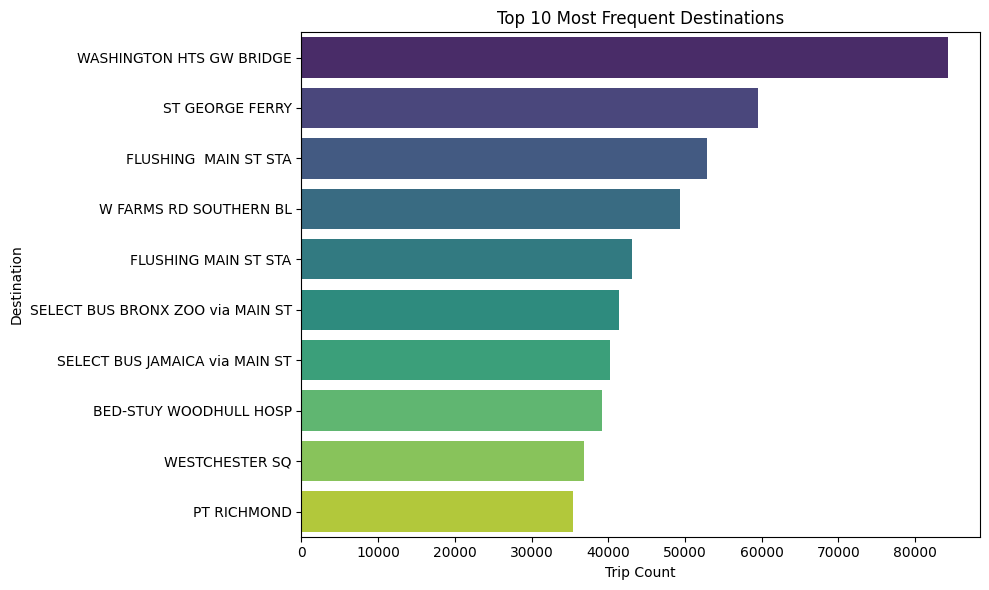

In [ ]:
#2. Plot Results using Visualization Libraries
# Convert to Pandas
top_dest_pd = top_dest_df.toPandas()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=top_dest_pd, x="trip_count", y="DestinationName", palette="viridis")
plt.title("Top 10 Most Frequent Destinations")
plt.xlabel("Trip Count")
plt.ylabel("Destination")
plt.tight_layout()
plt.show()


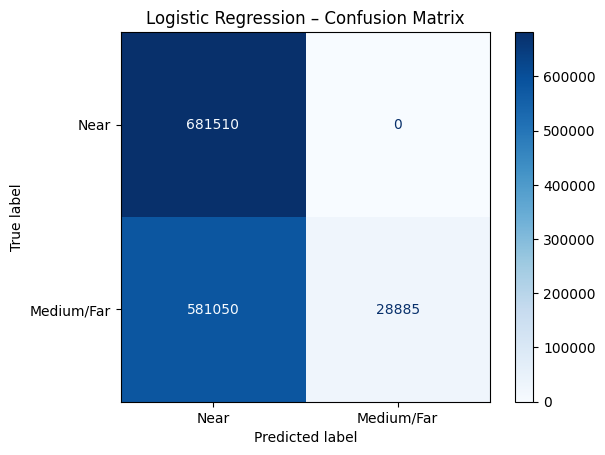

In [ ]:
#3. Visualize Model Predictions (Logistic Regression)
# Convert predictions to Pandas
lr_preds_pd = lr_preds.select("label", "prediction").toPandas()

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(lr_preds_pd["label"], lr_preds_pd["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Near", "Medium/Far"])
disp.plot(cmap="Blues")
plt.title("Logistic Regression – Confusion Matrix")
plt.show()


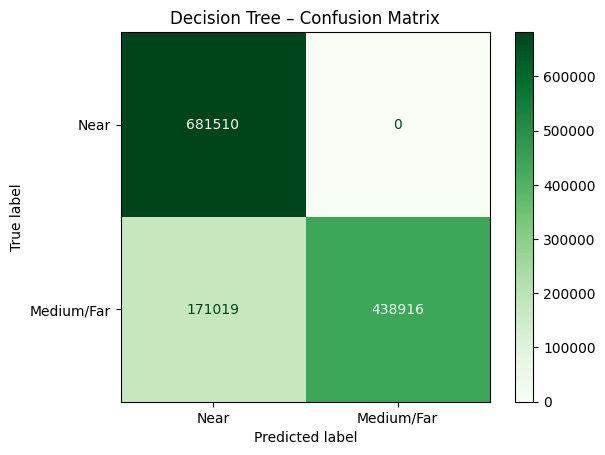

In [ ]:
# Convert Decision Tree predictions to Pandas
dt_preds_pd = dt_preds.select("label", "prediction").toPandas()

# Import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm_dt = confusion_matrix(dt_preds_pd["label"], dt_preds_pd["prediction"])

# Display
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Near", "Medium/Far"])
disp_dt.plot(cmap="Greens")
plt.title("Decision Tree – Confusion Matrix")
plt.show()


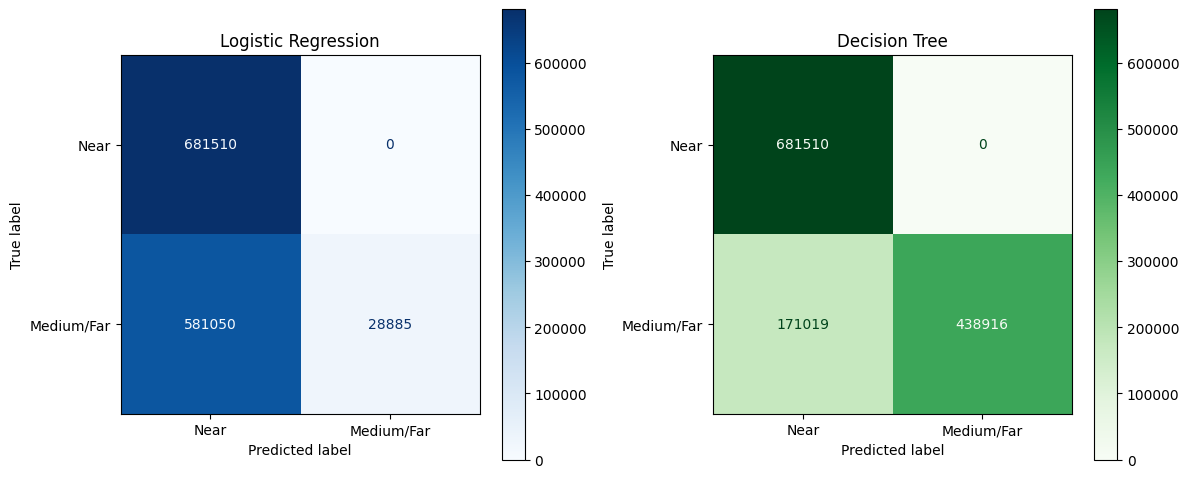

In [ ]:
#Show Side-by-Side Comparison
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# LR
cm_lr = confusion_matrix(lr_preds_pd["label"], lr_preds_pd["prediction"])
ConfusionMatrixDisplay(cm_lr, display_labels=["Near", "Medium/Far"]).plot(ax=ax[0], cmap="Blues")
ax[0].set_title("Logistic Regression")

# DT
ConfusionMatrixDisplay(cm_dt, display_labels=["Near", "Medium/Far"]).plot(ax=ax[1], cmap="Greens")
ax[1].set_title("Decision Tree")

plt.tight_layout()
plt.show()
